In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
from tqdm import tqdm

In [2]:
"""The goal of this notebook is to pick a handful of households from
the data set while ending up with as minimum Nan as possible! 
"""

'The goal of this notebook is to pick a handful of households from\nthe data set while ending up with as minimum Nan as possible! \n'

In [3]:
# We are using already clean data.!
source_data = Path("./london_dataset/")
block_data_path = source_data/'halfhourly_dataset'/'halfhourly_dataset'
block_data_path = source_data/'halfhourly_dataset'/'halfhourly_dataset'/'two_block'

In [4]:
block_1 = pd.read_csv(block_data_path/"block_1.csv", parse_dates=False)
block_1['tstp'] = pd.to_datetime(block_1['tstp'], yearfirst=True)
block_1.head()

# this is a sample from data!

,LCLid,tstp,energy(kWh/hh)
0,MAC000323,2012-03-06 14:00:00,0.488
1,MAC000323,2012-03-06 14:30:00,0.449
2,MAC000323,2012-03-06 15:00:00,0.424
3,MAC000323,2012-03-06 15:30:00,0.439
4,MAC000323,2012-03-06 16:00:00,0.291


In [5]:
# check for the NAN
check_nan = 0
for f in tqdm(block_data_path.glob("*.csv")):
    df = pd.read_csv(f, parse_dates=False, dtype=object)
    check_nan += df.isnull().sum().sum()
print(f"How many Nan did we have?: {check_nan}")
print('Data is clean!')
del df


0it [00:00, ?it/s]

10it [00:11,  1.12s/it]

How many Nan did we have?: 0
Data is clean!


In [6]:
# get the maximum end date and the length of each series:
list_data_prop = []
for f in tqdm(block_data_path.glob("*.csv")):
    df = pd.read_csv(f, parse_dates=False, dtype=object)
    df['tstp'] = pd.to_datetime(df['tstp'], yearfirst=True)
    list_data_prop.append(df.groupby('LCLid')['tstp'].agg(['min', 'max', 'count' ]))

10it [00:16,  1.62s/it]


In [7]:
# concatenate all the properties
df_prop = pd.concat(list_data_prop)
df_prop.head()

,min,max,count
LCLid,,,
MAC000026,2011-12-07 11:00:00,2014-02-28,39038
MAC000052,2011-12-08 15:00:00,2014-02-28,38976
MAC000105,2011-12-13 10:00:00,2014-02-12,37985
MAC000109,2011-12-13 13:30:00,2014-02-28,38757
MAC000377,2012-03-12 13:30:00,2014-02-28,34386


In [8]:
df_prop['max'].value_counts().head()
# then decide and drop all the series that does not end in the max
# What is a better way to better show the results?

max
2014-02-28 00:00:00    438
2014-01-08 00:00:00      3
2013-09-30 00:00:00      2
2013-11-20 23:30:00      2
2013-11-23 00:00:00      2
Name: count, dtype: int64

In [9]:
# get only those IDs that match the required max
max_date = df_prop['max'].value_counts().index[0]
df_same_end_diff_len = df_prop [df_prop['max'] == max_date]
df_same_end_diff_len.head()

,min,max,count
LCLid,,,
MAC000026,2011-12-07 11:00:00,2014-02-28,39038
MAC000052,2011-12-08 15:00:00,2014-02-28,38976
MAC000109,2011-12-13 13:30:00,2014-02-28,38757
MAC000377,2012-03-12 13:30:00,2014-02-28,34386
MAC000808,2012-04-25 11:00:00,2014-02-28,32281


<Axes: >

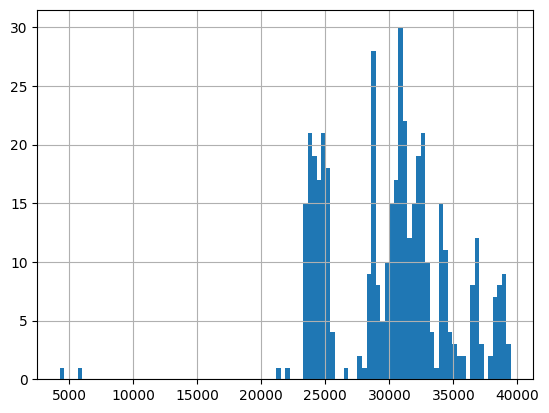

In [10]:
# pick the good length!
df_same_end_diff_len['count'].hist(bins=100)

# Beautify this figure!

In [11]:
# The bins already gives us a week difference
bins = np.arange(30000,32000,336)
df_cut = pd.cut(df_same_end_diff_len['count'], bins)
# count the number in each bin
vc = pd.value_counts(df_cut, sort=True)
vc

count
(30672, 31008]    28
(31008, 31344]    20
(30336, 30672]    17
(31344, 31680]    16
(30000, 30336]    13
Name: count, dtype: int64

In [12]:
# we pick this two length as find the corresponding length
lower_bound = vc.index.values[0].left
upper_bound = vc.index.values[1].mid

mask = (df_same_end_diff_len['count']>= lower_bound) & (df_same_end_diff_len['count'] <= upper_bound)
df_selected_households = df_same_end_diff_len[mask]

print("The data set with the series that have the same end date and a specified length:")
df_selected_households.head()

The data set with the series that have the same end date and a specified length:


,min,max,count
LCLid,,,
MAC001539,2012-05-22 11:30:00,2014-02-28,30982
MAC001613,2012-05-25 14:00:00,2014-02-28,30828
MAC004318,2012-05-25 09:00:00,2014-02-28,30843
MAC004249,2012-05-23 14:00:00,2014-02-28,30886
MAC001448,2012-05-21 11:00:00,2014-02-28,30939


In [13]:
# save the index for later use
selected_households = df_selected_households.index.values
path = source_data / 'household_names.npz'
np.savez(path, selected_households=selected_households)

In [14]:
# delete some data to free memory
del df_selected_households,  list_data_prop, block_1,\
        df_same_end_diff_len

In [15]:
"""We go over the csv files once again and this time only pick 
household that have the desired end date and length.
We save the data into a wide format for later use"""


'We go over the csv files once again and this time only pick \nhousehold that have the desired end date and length.\nWe save the data into a wide format for later use'

In [16]:

list_selected_household = []
for f in tqdm(block_data_path.glob("*.csv")):
    df = pd.read_csv(f, parse_dates=False, dtype='object')
    # to be safe 
    df['tstp'] = pd.to_datetime(df['tstp'], yearfirst=True) 
    # check if the LCLid in the selected housholds
    df = df[df.LCLid.isin(selected_households)]
    # Turn the date into wide format
    df_pivoted = df.pivot(values='energy(kWh/hh)', columns='LCLid', index='tstp')
    # drop the NA
    df_pivoted = df_pivoted.dropna(axis=0)
    list_selected_household.append(df_pivoted)


10it [00:16,  1.66s/it]


In [17]:
df_selected_households = pd.concat(list_selected_household, axis=1)
df_selected_households

LCLid,MAC001539,MAC001613,MAC004318,MAC004249,MAC001448,MAC004287,MAC001518,MAC001552,MAC001561,MAC001580,...,MAC001579,MAC001661,MAC001664,MAC001510,MAC001528,MAC001533,MAC001628,MAC001612,MAC001614,MAC001471
tstp,,,,,,,,,,,,,,,,,,,,,
2012-05-21 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.283
2012-05-21 14:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.345
2012-05-21 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.277
2012-05-21 15:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.181
2012-05-21 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-02-27 22:00:00,0.42,0.375,0.216,1.194,0.152,0.323,0.082,0.052,0.517,0.642,...,0.362,0.994,0.46,1.279,0.259,0.11,0.09,0.411,0.291,0.708
2014-02-27 22:30:00,0.276,0.519,0.194,1.268,0.135,0.45,0.066,0.053,0.425,0.709,...,0.375,0.355,0.413,0.742,0.245,0.253,0.096,0.208,0.35,0.137
2014-02-27 23:00:00,0.094,0.229,0.16,1.1619999,0.07,0.349,0.254,0.052,0.239,0.665,...,0.237,0.413,0.283,0.243,0.217,0.07,0.096,0.224,0.297,0.139


In [18]:
# drop the Nan
df_selected_households = df_selected_households.dropna(axis=0)
df_selected_households.head()

LCLid,MAC001539,MAC001613,MAC004318,MAC004249,MAC001448,MAC004287,MAC001518,MAC001552,MAC001561,MAC001580,...,MAC001579,MAC001661,MAC001664,MAC001510,MAC001528,MAC001533,MAC001628,MAC001612,MAC001614,MAC001471
tstp,,,,,,,,,,,,,,,,,,,,,
2012-05-28 12:00:00,0.216,0.664,0.096,1.201,0.094,0.45,0.047,0.106,0.207,0.188,...,0.405,0.596,0.222,0.146,0.346,0.126,0.063,0.103,0.109,0.424
2012-05-28 12:30:00,0.094,0.248,0.075,1.336,0.065,0.749,0.841,0.108,0.148,0.164,...,0.427,0.277,0.169,0.154,0.348,0.126,0.061,0.085,0.081,0.16
2012-05-28 13:00:00,0.094,0.156,0.046,0.909,0.09,0.277,0.781,0.106,0.403,0.157,...,0.364,0.186,0.17,0.12,0.532,0.073,0.052,0.123,0.131,0.163
2012-05-28 13:30:00,0.094,0.353,0.082,0.887,0.14,0.666,0.178,0.196,0.428,0.157,...,0.429,0.104,0.144,0.131,0.323,0.079,0.046,0.221,0.088,0.332
2012-05-28 14:00:00,0.094,0.175,0.016,0.97,0.063,0.329,0.03,0.11,0.234,0.162,...,0.393,0.132,0.187,0.104,0.348,0.166,0.047,0.194,0.112,0.337


In [19]:
# change type of the data for the columns
for column in df_selected_households.columns:
    df_selected_households.loc[:,column] = df_selected_households[column].astype('float')

# save some memory
del list_selected_household, df, df_pivoted


In [20]:
# resample to turn it into hourly data !!!
df_selected_households = df_selected_households.resample('60min', closed='right').sum() 
df_selected_households.head()

LCLid,MAC001539,MAC001613,MAC004318,MAC004249,MAC001448,MAC004287,MAC001518,MAC001552,MAC001561,MAC001580,...,MAC001579,MAC001661,MAC001664,MAC001510,MAC001528,MAC001533,MAC001628,MAC001612,MAC001614,MAC001471
tstp,,,,,,,,,,,,,,,,,,,,,
2012-05-28 11:00:00,0.216,0.664,0.096,1.201,0.094,0.45,0.047,0.106,0.207,0.188,...,0.405,0.596,0.222,0.146,0.346,0.126,0.063,0.103,0.109,0.424
2012-05-28 12:00:00,0.188,0.404,0.121,2.245,0.155,1.026,1.622,0.214,0.551,0.321,...,0.791,0.463,0.339,0.274,0.88,0.199,0.113,0.208,0.212,0.323
2012-05-28 13:00:00,0.188,0.528,0.098,1.857,0.203,0.995,0.208,0.306,0.662,0.319,...,0.822,0.236,0.331,0.235,0.671,0.245,0.093,0.415,0.2,0.669
2012-05-28 14:00:00,0.191,0.634,0.09,1.383,0.172,1.249,0.416,0.212,1.421,0.386,...,0.819,0.195,0.374,0.29,0.735,0.375,0.13,0.304,0.321,0.942
2012-05-28 15:00:00,0.266,0.506,0.095,1.292,0.197,0.677,0.067,0.213,1.552,0.299,...,0.786,0.165,0.525,0.256,0.747,0.292,0.25,0.313,0.224,0.842


In [21]:
# see how much memory we are using
print(f"Total memory usage: {df_selected_households.memory_usage().sum()/1024**2} MB")

Total memory usage: 3.753173828125 MB


In [22]:
# renaming the index before saving
df_selected_households.index.name = 'date'
df_selected_households.columns.name=''
# save the data
path = source_data / 'london_electricity.csv'
df_selected_households.to_csv(path, index=True)